## Домашняя работа по теме: "Задача lookalike (Positive Unlabeled Learning)"

Выполнила Моисеенкова Полина

__Задание__
1. взять любой набор данных для бинарной классификации (можно скачать один с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать feature engineering
3. обучить любой классификатор (какой вам нравится)
4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
5. применить random negative sampling для построения классификатора в новых условиях
6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
7. поэкспериментировать с долей P на шаге 6 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
import lightgbm as lgbm, catboost as catb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, ConfusionMatrixDisplay, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

Для выполнения задания выбрала датасет с сайта Kaggle __Hotel Reservations Dataset__ https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

In [2]:
df = pd.read_csv('Hotel Reservations.csv', sep=',')
df.head(3)

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

Посмотрим на числовые данные

In [4]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])

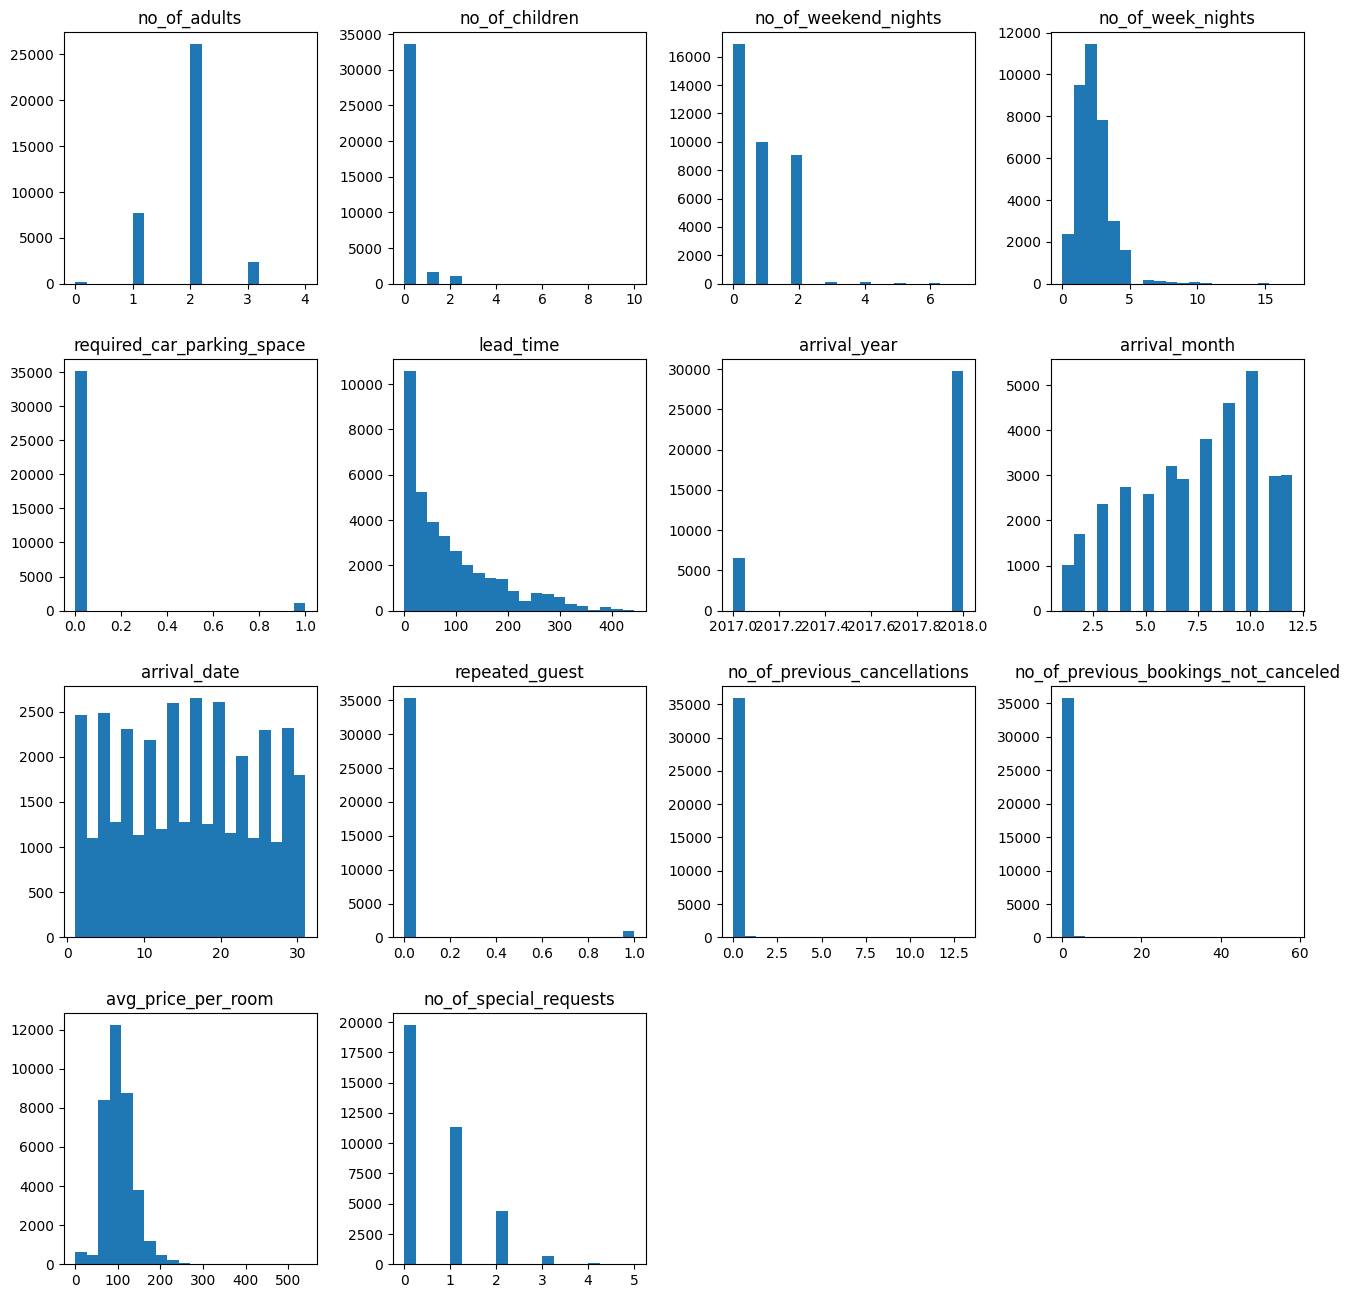

In [5]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

Отберем признаки, не требующие стандртизации.

In [6]:
no_changes = ['required_car_parking_space', 'repeated_guest']

Отберем признаки, для которых применимо OHE кодирование

In [7]:
df['arrival_year'].value_counts()

2018    29761
2017     6514
Name: arrival_year, dtype: int64

In [8]:
df['arrival_year'] = df['arrival_year'].map({2017: '2017', 2018: '2018'})
cat_columns = []
cat_columns.append('arrival_year')

Для остальных числовых признаков применим стандартизацию.

In [9]:
standard_features = [feature for feature in df_num_features if feature not in no_changes and feature not in cat_columns]
standard_features

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'lead_time',
 'arrival_month',
 'arrival_date',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests']

Посмотрим на категориальные признаки

In [10]:
df['type_of_meal_plan'].value_counts()

Meal Plan 1     27835
Not Selected     5130
Meal Plan 2      3305
Meal Plan 3         5
Name: type_of_meal_plan, dtype: int64

In [11]:
cat_columns.append('type_of_meal_plan')

In [12]:
df['room_type_reserved'].value_counts()

Room_Type 1    28130
Room_Type 4     6057
Room_Type 6      966
Room_Type 2      692
Room_Type 5      265
Room_Type 7      158
Room_Type 3        7
Name: room_type_reserved, dtype: int64

In [13]:
cat_columns.append('room_type_reserved')

In [14]:
df['market_segment_type'].value_counts()

Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: market_segment_type, dtype: int64

In [15]:
cat_columns.append('market_segment_type')

Посмотрим на целевую переменную

In [16]:
df['booking_status'].value_counts()

Not_Canceled    24390
Canceled        11885
Name: booking_status, dtype: int64

In [17]:
# заменим значения на 0 и 1
df['booking_status'] = df['booking_status'].map({'Not_Canceled': 0, 'Canceled': 1})
df['booking_status'].value_counts()

0    24390
1    11885
Name: booking_status, dtype: int64

In [18]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [19]:
cat_columns

['arrival_year',
 'type_of_meal_plan',
 'room_type_reserved',
 'market_segment_type']

In [20]:
standard_features

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'lead_time',
 'arrival_month',
 'arrival_date',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests']

In [21]:
no_changes

['required_car_parking_space', 'repeated_guest']

In [22]:
final_transformers = list()

for cat_col in cat_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in standard_features:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))


In [23]:
# объединим в единынй пайплайн
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats),
                            ('no_changes', no_changes)])

### Обучим модель на данных, где все таргеты известны

In [24]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['booking_status'], random_state=42, test_size=0.33)

In [25]:
def get_classification_report(y_test, y_score, b=1):

    """
    Функция для оценки качества модели

    """
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")
    plt.figure(figsize=(5, 4))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

    precision, recall, thresholds = precision_recall_curve(
        y_test, y_score)
    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
    print(f'ROC_AUC score is: {roc_auc_score(y_test, y_score)}')
    return {'fscore': fscore[ix], 'precision': precision[ix],
            'recall': recall[ix], 'roc_auc_score': roc_auc_score(y_test, y_score)}

In [26]:
def ML_algorithm(ML_function, X_train, y_train, X_test):
    classifier = Pipeline([
        ('features',feats),
        ('classifier', ML_function),
    ])

    #запустим кросс-валидацию
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)

    #обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_test_pred = classifier.predict(X_test)
    try:
        y_score = classifier.predict_proba(X_test)[:, 1]
    except:
        y_score = 0
    if not isinstance(y_score, int):
        results = {'y_score': y_score, 'y_test_pred': y_test_pred, 'classifier': classifier}
        return results
    else:
        results = {'y_test_pred': y_test_pred, 'classifier': classifier}
        return results

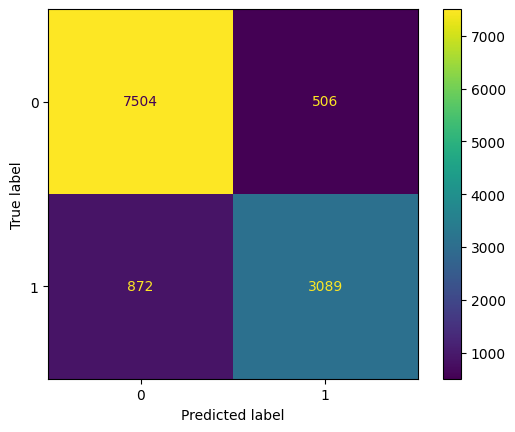

In [27]:
lightGBM = ML_algorithm(lgbm.LGBMClassifier(random_state=42), X_train, y_train, X_test)
ConfusionMatrixDisplay.from_estimator(lightGBM['classifier'], X_test, y_test)

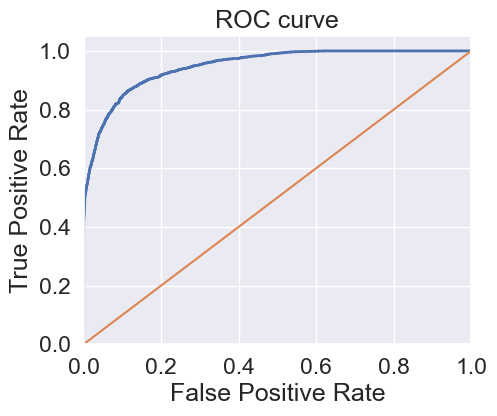

Best Threshold=0.331505, F-Score=0.827, Precision=0.806, Recall=0.849
ROC_AUC score is: 0.9486214057724487


In [28]:
lightGBM_report = get_classification_report(y_test=np.array(y_test),
                        y_score=lightGBM['y_score'])

Результаты очень хорошие.

### Теперь очередь за PU learning

Представим, что нам неизвестны негативы и часть позитивов

In [29]:
def ModDataFunc(per=0.25):

    """Функция для выбора только части таргетов с значеним 1.
    Количество определяется в условиии в процентном соотношении"""

    mod_data = df.copy()
    #get the indices of the positives samples
    pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
    #shuffle them
    np.random.shuffle(pos_ind)
    # leave just 25% of the positives marked
    pos_sample_len = int(np.ceil(per * len(pos_ind)))
    print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
    pos_sample = pos_ind[:pos_sample_len]
    # Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)
    mod_data['class_test'] = -1
    mod_data.loc[pos_sample,'class_test'] = 1
    print('target variable:\n', mod_data.iloc[:,-1].value_counts())
    return mod_data

In [30]:
mod_data_10 = ModDataFunc(per=0.1)

Using 1189/11885 as positives and unlabeling the rest
target variable:
 -1    35086
 1     1189
Name: class_test, dtype: int64


### 1. random negative sampling

In [31]:
def RandomNegativeSamplimg(mod_data):
    mod_data = mod_data.sample(frac=1)
    neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
    sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
    pos_sample = mod_data[mod_data['class_test']==1]
    print(neg_sample.shape, pos_sample.shape)
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)
    return {'X_train': sample_train.iloc[:,:-2],
     'y_train': sample_train.iloc[:,-2],
     'X_test': sample_test.iloc[:,:-2],
     'y_test': sample_test.iloc[:,-2]}

In [32]:
data_10 = RandomNegativeSamplimg(mod_data_10)

(1189, 20) (1189, 20)


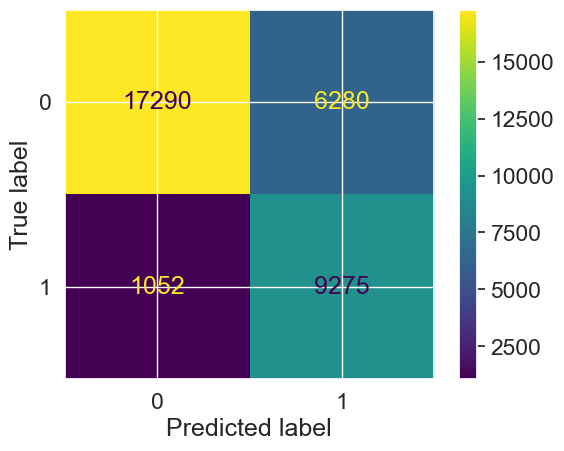

In [33]:
lightGBM_10 = ML_algorithm(lgbm.LGBMClassifier(random_state=42), data_10['X_train'], data_10['y_train'], data_10['X_test'])
ConfusionMatrixDisplay.from_estimator(lightGBM_10['classifier'], data_10['X_test'], data_10['y_test'])

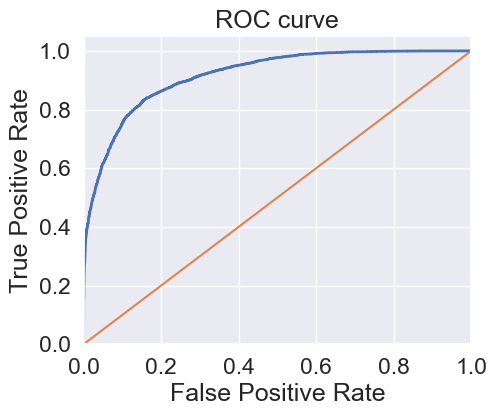

Best Threshold=0.799581, F-Score=0.766, Precision=0.753, Recall=0.779
ROC_AUC score is: 0.9171711959936795


In [34]:
lightGBM_report_10 = get_classification_report(y_test=np.array(data_10['y_test']),
                        y_score=lightGBM_10['y_score'])

Модель показала неплохие результаты на 10% "позитивов", теперь попробуем на 50%

In [35]:
mod_data_50 = ModDataFunc(per=0.5)

Using 5943/11885 as positives and unlabeling the rest
target variable:
 -1    30332
 1     5943
Name: class_test, dtype: int64


In [36]:
data_50 = RandomNegativeSamplimg(mod_data_50)

(5943, 20) (5943, 20)


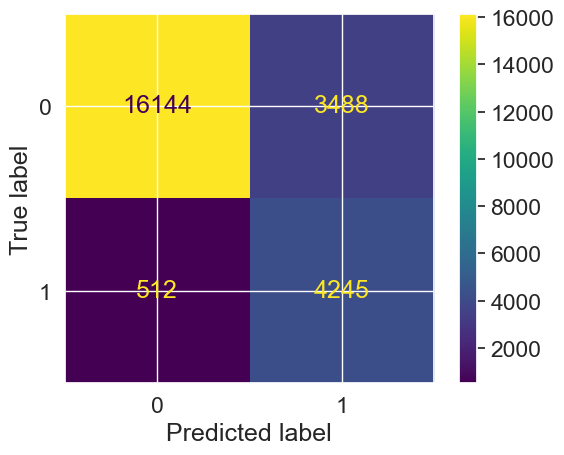

In [37]:
lightGBM_50 = ML_algorithm(lgbm.LGBMClassifier(random_state=42), data_50['X_train'], data_50['y_train'], data_50['X_test'])
ConfusionMatrixDisplay.from_estimator(lightGBM_50['classifier'], data_50['X_test'], data_50['y_test'])

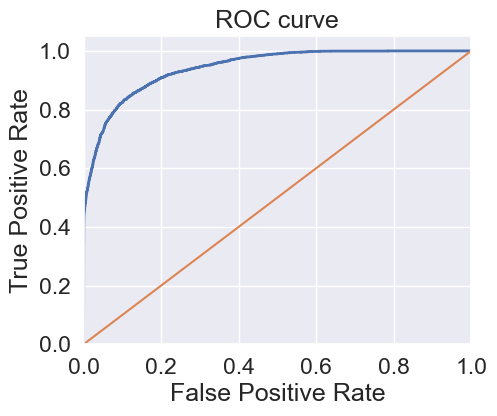

Best Threshold=0.799692, F-Score=0.758, Precision=0.762, Recall=0.754
ROC_AUC score is: 0.943316092194765


In [38]:
lightGBM_report_50 = get_classification_report(y_test=np.array(data_50['y_test']),
                        y_score=lightGBM_50['y_score'])

F-score ухудшился

Теперь попробуем на 90% позитивов

In [39]:
mod_data_90 = ModDataFunc(per=0.9)

Using 10697/11885 as positives and unlabeling the rest
target variable:
 -1    25578
 1    10697
Name: class_test, dtype: int64


In [40]:
data_90 = RandomNegativeSamplimg(mod_data_90)

(10697, 20) (10697, 20)


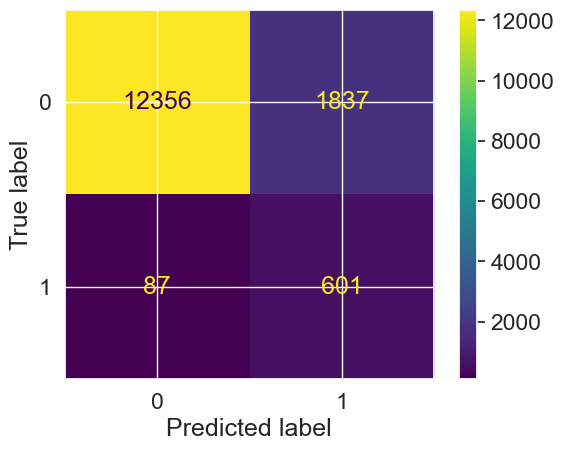

In [41]:
lightGBM_90 = ML_algorithm(lgbm.LGBMClassifier(random_state=42), data_90['X_train'], data_90['y_train'], data_90['X_test'])
ConfusionMatrixDisplay.from_estimator(lightGBM_90['classifier'], data_90['X_test'], data_90['y_test'])

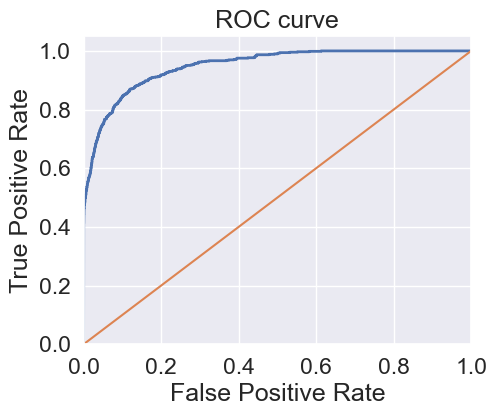

Best Threshold=0.887531, F-Score=0.632, Precision=0.864, Recall=0.499
ROC_AUC score is: 0.9488061896709645


In [42]:
lightGBM_report_90 = get_classification_report(y_test=np.array(data_90['y_test']),
                        y_score=lightGBM_90['y_score'])

In [43]:
data_90['y_train'].value_counts()

1    11197
0    10197
Name: booking_status, dtype: int64

F-score стал еще хуже. Сведем все результаты в таблицу

In [44]:
all_reports = [lightGBM_report, lightGBM_report_10, lightGBM_report_50, lightGBM_report_90]

In [45]:
table = {'precision': [report['precision'].round(3) for report in all_reports],
        'recall': [report['recall'].round(3) for report in all_reports],
        'roc_auc_score': [report['roc_auc_score'].round(3) for report in all_reports],
        'f_score': [report['fscore'].round(3) for report in all_reports]}
table = pd.DataFrame(data=table, index=['lightGBM_classic', 'lightGBM_10', 'lightGBM_50', 'lightGBM_90'])
table

,precision,recall,roc_auc_score,f_score
lightGBM_classic,0.806,0.849,0.949,0.827
lightGBM_10,0.753,0.779,0.917,0.766
lightGBM_50,0.762,0.754,0.943,0.758
lightGBM_90,0.864,0.499,0.949,0.632


Лучше всего f-score на полном датасете. Показатели ухудшаются, когда используем PU learning. Если говорить о PU learning, то лучше всего себя проявила модель с меньшим набором позитивных примеров, скорее всего такие результаты можно обьяснить изначальным дисбалансом классов.